In [1]:
from IPython.display import Image

# Labeling: Fixed Horizon

![image_example](img/fixed_horizon_labels_example.png)
_*Fig. 1:*_ Distribution of labels for standardized returns on closing prices of SPY in the time period from Jan 2008 to July 2016 using a 20 day rolling window for the standard deviation.


## Abstract

Fixed Horizon is a classification labelling technique in which time-indexed data is labeled according to whether it exceeds, falls in between, or is less than a threshold. This method is most commonly used with time bars, but also be applied to any time-indexed data such as dollar or volume bars. The subsequent labelled data can then be used as training and test data for ML algorithms.

The following paper outlines the technique in greater depth, and is followed closely in this notebook tutorial: ["Classification-based Financial Markets Prediction using Deep Neural Networks"](https://arxiv.org/abs/1603.08604) by _Dixon et al._ (2016). 


## How it works

Fixed time horizon is a common method used in labeling financial data, usually applied on time bars. The forward rate of return relative
to $t_0$ over time horizon $h$ is calculated as follows:


   $$r_{t0,t1} = \frac{p_{t1}}{p_{t0}} - 1$$

Where $t_1 = t_0 + h$ is the time bar index after a fixed horizon of $h$ ticks have passed, and $p_{t0}, p_{t1}$
are prices at times $t_0, t_1$. This method assigns a label based on comparison of rate of return to a threshold $\tau$
\[Lopez de Prado 2018\]:

$$
     \begin{equation}
     \begin{split}
       L_{t0, t1} = \begin{cases}
       -1 &\ \text{if} \ \ r_{t0, t1} < -\tau\\
       0 &\ \text{if} \ \ -\tau \leq r_{t0, t1} \leq \tau\\
       1 &\ \text{if} \ \ r_{t0, t1} > \tau
       \end{cases}
     \end{split}
     \end{equation}
$$

Though time bars are the most common format for financial data, there can be potential problems with over reliance on time bars. First,
time bars exhibit high seasonality, as trading behavior may be quite different at the open or close versus midday; thus it will not be
informative to apply the same thershold on non-uniform distribution. Solutions include applying the fixed horizon method to tick or
volume bars instead of time bars, using data sampled at the same time every day (e.g. closing prices) or inputting a dynamic threshold
as a pd.Series corresponding to the times in the dataset. Another solution is to apply the labels to data based on standardized returns \[Lopez de Prado, 2020: p.66\]. In this case, the data is scaled by mean and standard deviation based on a given rolling window before labels are applied.

---
## Examples of use

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf

from mlfinlab.labeling import fixed_time_horizon

import matplotlib.pyplot as plt

In [3]:
# Load price data
msft = yf.Ticker('MSFT')
msft_df = msft.history(start='2010-1-1', end ='2020-5-18')

# Subset closing prices
close = msft_df['Close']
close.head()

Date
2010-01-04    24.23
2010-01-05    24.23
2010-01-06    24.09
2010-01-07    23.84
2010-01-08    24.00
Name: Close, dtype: float64

### Labeling Financial Time Series

In [4]:
# Getting labels for a constant threshold of 1%. Will return 1 if the daily return is greater than 1%,
# -1 if less than -1%, and  0 if in between.
bars1 = fixed_time_horizon(close, 0.01, look_forward=1)
bars1.value_counts()

 0.0    1596
 1.0     560
-1.0     453
dtype: int64

Text(0, 0.5, 'Frequency')

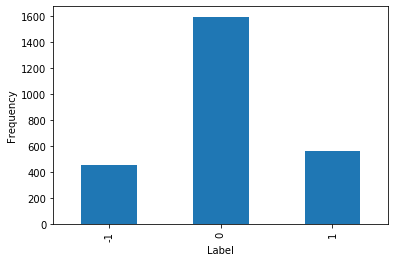

In [5]:
ax1 = bars1.value_counts().reindex([-1, 0, 1]).plot(kind='bar', x='label', y='frequency')
ax1.set_xlabel('Label')
ax1.set_ylabel('Frequency')

Predictably, lowering the threshold results in fewer 0 labels.

Text(0, 0.5, 'Frequency')

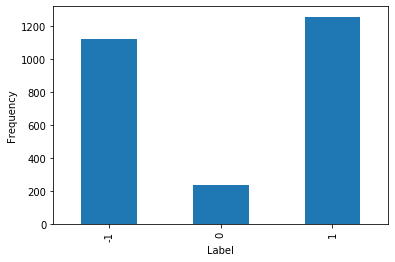

In [6]:
bars2 = fixed_time_horizon(close, 0.001, look_forward=1)
ax2 = bars2.value_counts().reindex([-1, 0, 1]).plot(kind='bar', x='label', y='frequency')
ax2.set_xlabel('Label')
ax2.set_ylabel('Frequency')

### Labeling With Dynamic Threshold

A major problem with the fixed time horizon method is the __seasonality__ of the data. Time bars in the middle of the trading day would look very different than those at the open or close. One way to get around this is to only use data which has been collected at the same time per day, such as close prices. Another method is to apply a dynamic threshold which can adjust for such differences. 

We will demonstrate two methods of setting a dynamic threshold:
1. Using a rolling standard deviation
2. Using SPY as the market return


In [7]:
# Get rolling standard deviation
msft_returns = close.pct_change(periods=1).shift(-1)
rolling_std = msft_returns.rolling(10).std()

In [8]:
bars3 = fixed_time_horizon(close, rolling_std, look_forward=1)
bars3.value_counts()

 0.0    1780
 1.0     463
-1.0     357
dtype: int64

Text(0, 0.5, 'Frequency')

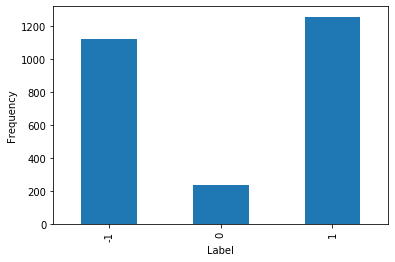

In [9]:
bars3 = fixed_time_horizon(close, 0.001, look_forward=1)
ax3 = bars3.value_counts().reindex([-1, 0, 1]).plot(kind='bar', x='label', y='frequency')
ax3.set_xlabel('Label')
ax3.set_ylabel('Frequency')

In [10]:
# Threshold based on market returns
spy = yf.Ticker('SPY')
spy_df = spy.history(start='2010-1-1', end ='2020-5-18')
market_close = spy_df['Close']

market_returns = market_close.pct_change(1).shift(-1)
market_returns.head()

Date
2010-01-04    0.002602
2010-01-05    0.000757
2010-01-06    0.004213
2010-01-07    0.003335
2010-01-08    0.001394
Name: Close, dtype: float64

In [11]:
close.pct_change(periods=1).shift(-1)

Date
2010-01-04    0.000000
2010-01-05   -0.005778
2010-01-06   -0.010378
2010-01-07    0.006711
2010-01-08   -0.012917
                ...   
2020-05-11   -0.022661
2020-05-12   -0.015110
2020-05-13    0.004351
2020-05-14    0.014553
2020-05-15         NaN
Name: Close, Length: 2610, dtype: float64

In [12]:
bars4 = fixed_time_horizon(close, market_returns, look_forward=1)
bars4.value_counts()

 1.0    1319
-1.0     837
 0.0     453
dtype: int64

Text(0, 0.5, 'Frequency')

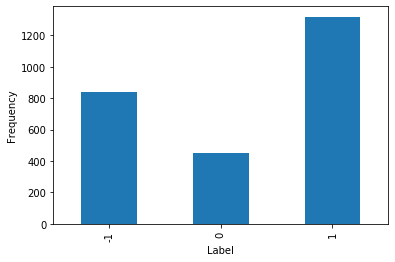

In [13]:
ax4 = bars4.value_counts().reindex([-1, 0, 1]).plot(kind='bar', x='label', y='frequency')
ax4.set_xlabel('Label')
ax4.set_ylabel('Frequency')

### Labeling with Standardization 

Scaling each return by the mean and standard deviation is also a potential solution in getting around the non-homogeneaity of the data, as it could adjust for volatility differences between different bars. If standardization is desires, a rolling window must be given.

In [14]:
bars5 = fixed_time_horizon(close, 1, look_forward=1, standardized=True, window=5)
bars5.value_counts()

 0.0    1787
 1.0     415
-1.0     403
dtype: int64

Text(0, 0.5, 'Frequency')

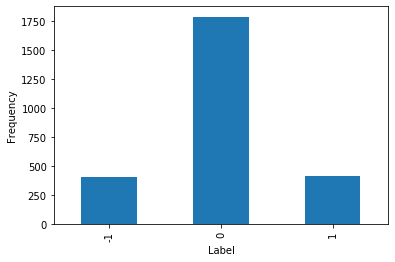

In [15]:
ax5 = bars5.value_counts().reindex([-1, 0, 1]).plot(kind='bar', x='label', y='frequency')
ax5.set_xlabel('Label')
ax5.set_ylabel('Frequency')

### Error Handling

Warnings will be raised if look_forward or window is greater than the length of the data. In this case, the function will still run, but all labels will be NaN. An error is raised if standardized is set to True but the window is not specified correctly (as an int).

In [16]:
fixed_time_horizon(close, 0.01, look_forward=99999999)

c:\users\ruifan\mlfinlab\mlfinlab\labeling\fixed_time_horizon.py:45: UserWarning: look_forward period is greater than the length of the Series. All labels will be NaN.
  UserWarning)


Date
2010-01-04   NaN
2010-01-05   NaN
2010-01-06   NaN
2010-01-07   NaN
2010-01-08   NaN
              ..
2020-05-11   NaN
2020-05-12   NaN
2020-05-13   NaN
2020-05-14   NaN
2020-05-15   NaN
Length: 2610, dtype: float64

In [17]:
fixed_time_horizon(close, 0.01, look_forward=1, standardized=True, window=99999999)

c:\users\ruifan\mlfinlab\mlfinlab\labeling\fixed_time_horizon.py:53: UserWarning: window is greater than the length of the Series. All labels will be NaN.
  warnings.warn('window is greater than the length of the Series. All labels will be NaN.', UserWarning)


Date
2010-01-04   NaN
2010-01-05   NaN
2010-01-06   NaN
2010-01-07   NaN
2010-01-08   NaN
              ..
2020-05-11   NaN
2020-05-12   NaN
2020-05-13   NaN
2020-05-14   NaN
2020-05-15   NaN
Length: 2610, dtype: float64

In [18]:
fixed_time_horizon(close, 0.01, look_forward=1, standardized=True)

AssertionError: when standardized is True, window must be int

---
## Conclusion

This notebook presents the fixed horizon method, a simple method of labeling data for later use in machine learning algorithms. In this process:
 - Forward rates of return for assets are calculated based on tick data, usually in the form of time bars.
 - The forward return rate is compared to a threshold for the return. The threshold can be a constant, or a dynamic series corresponding to every timestamp in the data.
 - Each observation is compared to the threshold, and is labeled -1 if it is below -threshold, 0 if it is between -threshold and +threshold, and 1 if it is greater than +threshold.

In Dixon's paper, the data is labelled using this method. Subsequently a neural network is trained to to predict the label based on the data. A simple trading strategy in which a long position is taken if a ticker is classified as 1, and short if it's classified at -1, can then be applied.

## References

1. Dixon, M., Klabjan, D. and Jin Hoon, B., 2020. Classification-based Financial Markets Prediction using Deep Neural Networks. arXiv, [online] Available at: https://arxiv.org/abs/1603.08604

2. López de Prado, M., 2018. Advances In Financial Machine Learning. pp.43-44.

3. López de Prado, M., 2020. Machine Learning For Asset Managers. pp.65-66.
